In [28]:
import os
import sys

import pandas as pd
import time
import numpy as np


import argparse

import torch
import torch.nn as nn
import torch.optim as optim

from typing import Optional

import itertools
from torch import Tensor
import matplotlib.pyplot as plt

from collections import Counter


from torch.distributions import Categorical

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors

import random

from sklearn.metrics import accuracy_score

import pprint

# IMLE Related Libraries

In [2]:
# -*- coding: utf-8 -*-

import math

import torch
from torch import Tensor, Size
from torch.distributions.gamma import Gamma
from torch.distributions.gumbel import Gumbel

from abc import ABC, abstractmethod

from typing import Optional

import logging

logger = logging.getLogger(__name__)


class BaseNoiseDistribution(ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def sample(self,
               shape: Size) -> Tensor:
        raise NotImplementedError


class SumOfGammaNoiseDistribution(BaseNoiseDistribution):
    r"""
    Creates a generator of samples for the Sum-of-Gamma distribution [1], parameterized
    by :attr:`k`, :attr:`nb_iterations`, and :attr:`device`.

    [1] Mathias Niepert, Pasquale Minervini, Luca Franceschi - Implicit MLE: Backpropagating Through Discrete
    Exponential Family Distributions. NeurIPS 2021 (https://arxiv.org/abs/2106.01798)

    Example::

        >>> import torch
        >>> noise_distribution = SumOfGammaNoiseDistribution(k=5, nb_iterations=100)
        >>> noise_distribution.sample(torch.Size([5]))
        tensor([ 0.2504,  0.0112,  0.5466,  0.0051, -0.1497])

    Args:
        k (float): k parameter -- see [1] for more details.
        nb_iterations (int): number of iterations for estimating the sample.
        device (torch.devicde): device where to store samples.
    """
    def __init__(self,
                 k: float,
                 nb_iterations: int = 10,
                 device: Optional[torch.device] = None):
        super().__init__()
        self.k = k
        self.nb_iterations = nb_iterations
        self.device = device

    def sample(self,
               shape: Size) -> Tensor:
        samples = torch.zeros(size=shape, dtype=torch.float, device=self.device)

        for i in range(1, self.nb_iterations + 1):
            concentration = torch.tensor(1. / self.k, dtype=torch.float, device=self.device)
            rate = torch.tensor(i / self.k, dtype=torch.float, device=self.device)

            gamma = Gamma(concentration=concentration, rate=rate)
            samples = samples + gamma.sample(sample_shape=shape).to(self.device)

        samples = (samples - math.log(self.nb_iterations)) / self.k
        return samples.to(self.device)


class GumbelNoiseDistribution(BaseNoiseDistribution):
    def __init__(self,
                 location: float = 0.0,
                 scale: float = 1.0,
                 device: Optional[torch.device] = None):
        super().__init__()
        self.location = torch.tensor(location, dtype=torch.float, device=device)
        self.scale = torch.tensor(scale, dtype=torch.float, device=device)
        self.device = device

        self.distribution = Gumbel(loc=self.location, scale=self.scale)

    def sample(self,
               shape: Size) -> Tensor:
        return self.distribution.sample(sample_shape=shape).to(self.device)


In [3]:
#-*- coding: utf-8 -*-

import torch

from torch import Tensor
from abc import ABC, abstractmethod

from typing import Optional

import logging

logger = logging.getLogger(__name__)


class BaseTargetDistribution(ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def params(self,
               theta: Tensor,
               dy: Optional[Tensor]) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def process(self,
                theta: Tensor,
                dy: Tensor,
                gradient: Tensor) -> Tensor:
        return gradient


class TargetDistribution(BaseTargetDistribution):
    r"""
    Creates a generator of target distributions parameterized by :attr:`alpha` and :attr:`beta`.

    Example::

        >>> import torch
        >>> target_distribution = TargetDistribution(alpha=1.0, beta=1.0)
        >>> target_distribution.params(theta=torch.tensor([1.0]), dy=torch.tensor([1.0]))
        tensor([2.])

    Args:
        alpha (float): weight of the initial distribution parameters theta
        beta (float): weight of the downstream gradient dy
        do_gradient_scaling (bool): whether to scale the gradient by 1/λ or not
    """
    def __init__(self,
                 alpha: float = 1.0,
                 beta: float = 1.0,
                 do_gradient_scaling: bool = False,
                 eps: float = 1e-7):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.do_gradient_scaling = do_gradient_scaling
        self.eps = eps

    def params(self,
               theta: Tensor,
               dy: Optional[Tensor],
               alpha: Optional[float] = None,
               beta: Optional[float] = None) -> Tensor:
        alpha_ = self.alpha if alpha is None else alpha
        beta_ = self.beta if beta is None else beta

        theta_prime = alpha_ * theta - beta_ * (dy if dy is not None else 0.0)
        return theta_prime

    def process(self,
                theta: Tensor,
                dy: Tensor,
                gradient_3d: Tensor) -> Tensor:
        scaling_factor = max(self.beta, self.eps)
        res = (gradient_3d / scaling_factor) if self.do_gradient_scaling is True else gradient_3d
        return res


class AdaptiveTargetDistribution(BaseTargetDistribution):
    def __init__(self,
                 initial_alpha: float = 1.0,
                 initial_beta: float = 1.0,
                 initial_grad_norm: float = 1.0,
                 # Pitch: the initial default hyperparams lead to very stable results,
                 # competitive with manually tuned ones -- E.g. try with 1e-3 for this hyperparam
                 beta_update_step: float = 0.0001,
                 beta_update_momentum: float = 0.0,
                 grad_norm_decay_rate: float = 0.9,
                 target_norm: float = 1.0):
        super().__init__()
        self.alpha = initial_alpha
        self.beta = initial_beta

        self.grad_norm = initial_grad_norm
        self.beta_update_step = beta_update_step
        self.beta_update_momentum = beta_update_momentum
        self.previous_beta_update = 0.0
        self.grad_norm_decay_rate = grad_norm_decay_rate
        self.target_norm = target_norm

    def _perturbation_magnitude(self,
                                theta: Tensor,
                                dy: Optional[Tensor]):
        norm_dy = torch.linalg.norm(dy).item() if dy is not None else 1.0
        return 0.0 if norm_dy <= 0.0 else self.beta * (torch.linalg.norm(theta) / norm_dy)

    def params(self,
               theta: Tensor,
               dy: Optional[Tensor]) -> Tensor:
        pm = self._perturbation_magnitude(theta, dy)
        theta_prime = self.alpha * theta - pm * (dy if dy is not None else 0.0)
        return theta_prime

    def process(self,
                theta: Tensor,
                dy: Tensor,
                gradient_3d: Tensor) -> Tensor:
        batch_size = gradient_3d.shape[0]
        nb_samples = gradient_3d.shape[1]
        pm = self._perturbation_magnitude(theta, dy)

        # We compute an exponentially decaying sum of the gradient norms
        grad_nnz = torch.count_nonzero(gradient_3d).float()
        nb_gradients = batch_size * nb_samples

        # Running estimate of the gradient norm (number of non-zero elements for every sample)
        self.grad_norm = self.grad_norm_decay_rate * self.grad_norm + \
                         (1.0 - self.grad_norm_decay_rate) * (grad_nnz / nb_gradients)

        # If the gradient norm is lower than 1, we increase beta; otherwise, we decrease beta.
        beta_update_ = (1.0 if self.grad_norm.item() < self.target_norm else - 1.0) * self.beta_update_step
        beta_update = (self.beta_update_momentum * self.previous_beta_update) + beta_update_

        # print('Momentum', self.beta_update_momentum, 'previous update', self.previous_beta_update,
        #       'current update', beta_update_, 'final update', beta_update, 'norm', self.grad_norm.item())

        # Enforcing \beta \geq 0
        self.beta = max(self.beta + beta_update, 0.0)
        self.previous_beta_update = beta_update

        res = gradient_3d / (pm if pm > 0.0 else 1.0)
        return res


In [4]:
# -*- coding: utf-8 -*-

import functools

import torch
from torch import Tensor

# from imle.noise import BaseNoiseDistribution
# from imle.target import BaseTargetDistribution, TargetDistribution

from typing import Optional, Callable

import logging

logger = logging.getLogger(__name__)


def imle(function: Optional[Callable[[Tensor], Tensor]] = None,
         target_distribution: Optional[BaseTargetDistribution] = None,
         noise_distribution: Optional[BaseNoiseDistribution] = None,
         nb_samples: int = 1,
         theta_noise_temperature: float = 1.0,
         target_noise_temperature: float = 1.0):
    r"""Turns a black-box combinatorial solver in an Exponential Family distribution via Perturb-and-MAP and I-MLE [1].

    The input function (solver) needs to return the solution to the problem of finding a MAP state for a constrained
    exponential family distribution -- this is the case for most black-box combinatorial solvers [2]. If this condition
    is violated though, the result would not hold and there is no guarantee on the validity of the obtained gradients.

    This function can be used directly or as a decorator.

    [1] Mathias Niepert, Pasquale Minervini, Luca Franceschi - Implicit MLE: Backpropagating Through Discrete
    Exponential Family Distributions. NeurIPS 2021 (https://arxiv.org/abs/2106.01798)
    [2] Marin Vlastelica, Anselm Paulus, Vít Musil, Georg Martius, Michal Rolínek - Differentiation of Blackbox
    Combinatorial Solvers. ICLR 2020 (https://arxiv.org/abs/1912.02175)

    Example:

        >>> from imle.imle import imle
        >>> from imle.target import TargetDistribution
        >>> from imle.noise import SumOfGammaNoiseDistribution
        >>> from imle.solvers import select_k
        >>> target_distribution = TargetDistribution(alpha=0.0, beta=10.0)
        >>> noise_distribution = SumOfGammaNoiseDistribution(k=21, nb_iterations=100)
        >>> @imle(target_distribution=target_distribution, noise_distribution=noise_distribution, nb_samples=100,
        >>>       theta_noise_temperature=theta_noise_temperature, target_noise_temperature=5.0)
        >>> def imle_select_k(weights_batch: Tensor) -> Tensor:
        >>>     return select_k(weights_batch, k=10)

    Args:
        function (Callable[[Tensor], Tensor]): black-box combinatorial solver
        target_distribution (Optional[BaseTargetDistribution]): factory for target distributions
        noise_distribution (Optional[BaseNoiseDistribution]): noise distribution
        nb_samples (int): number of noise sammples
        theta_noise_temperature (float): noise temperature for the input distribution
        target_noise_temperature (float): noise temperature for the target distribution
    """
    if target_distribution is None:
        target_distribution = TargetDistribution(alpha=1.0, beta=1.0)

    if function is None:
        return functools.partial(imle,
                                 target_distribution=target_distribution,
                                 noise_distribution=noise_distribution,
                                 nb_samples=nb_samples,
                                 theta_noise_temperature=theta_noise_temperature,
                                 target_noise_temperature=target_noise_temperature)

    @functools.wraps(function)
    def wrapper(theta: Tensor, *args):
        class WrappedFunc(torch.autograd.Function):

            @staticmethod
            def forward(ctx, theta: Tensor, *args):
                # [BATCH_SIZE, ...]
                theta_shape = theta.shape

                batch_size = theta_shape[0]
                instance_shape = theta_shape[1:]

                # [BATCH_SIZE, N_SAMPLES, ...]
                perturbed_theta_shape = [batch_size, nb_samples] + list(instance_shape)

                # ε ∼ ρ(ε)
                if noise_distribution is None:
                    noise = torch.zeros(size=perturbed_theta_shape, device=theta.device)
                else:
                    noise = noise_distribution.sample(shape=torch.Size(perturbed_theta_shape)).to(theta.device)

                # [BATCH_SIZE, N_SAMPLES, ...]
                eps = noise * theta_noise_temperature

                # [BATCH_SIZE, N_SAMPLES, ...]
                perturbed_theta_3d = theta.view(batch_size, 1, -1).repeat(1, nb_samples, 1).view(perturbed_theta_shape)
                perturbed_theta_3d = perturbed_theta_3d + eps

                # [BATCH_SIZE * N_SAMPLES, ...]
                perturbed_theta_2d = perturbed_theta_3d.view([-1] + perturbed_theta_shape[2:])

                perturbed_theta_2d_shape = perturbed_theta_2d.shape
                assert perturbed_theta_2d_shape[0] == batch_size * nb_samples

                # z = MAP(θ + ε)
                # [BATCH_SIZE * N_SAMPLES, ...]
                #print('perturbed_theta_2d',perturbed_theta_2d,perturbed_theta_2d.shape)
                z_2d = function(perturbed_theta_2d)
                assert z_2d.shape == perturbed_theta_2d_shape

                # [BATCH_SIZE, N_SAMPLES, ...]
                z_3d = z_2d.view(perturbed_theta_shape)

                ctx.save_for_backward(theta, noise, z_3d)

                # return z
                # [BATCH_SIZE * N_SAMPLES, ...]
                return z_2d

            @staticmethod
            def backward(ctx, dy):
                #print(dy,dy.shape)
                # theta: [BATCH_SIZE, ...]
                # noise: [BATCH_SIZE, N_SAMPLES, ...]
                # z_3d: [BATCH_SIZE, N_SAMPLES, ...]
                theta, noise, z_3d = ctx.saved_tensors

                theta_shape = theta.shape
                batch_size = theta_shape[0]

                # dy is [BATCH_SIZE * N_SAMPLES, ...]
                dy_shape = dy.shape
                # noise is [BATCH_SIZE, N_SAMPLES, ...]
                noise_shape = noise.shape

                assert noise_shape == z_3d.shape

                # [BATCH_SIZE * NB_SAMPLES, ...]
                theta_2d = theta.view(batch_size, 1, -1).repeat(1, nb_samples, 1).view(dy_shape)
                # θ' = θ - λ dy
                target_theta_2d = target_distribution.params(theta_2d, dy)

                # [BATCH_SIZE, NB_SAMPLES, ...]
                target_theta_3d = target_theta_2d.view(noise_shape)

                # [BATCH_SIZE, NB_SAMPLES, ...]
                eps = noise * target_noise_temperature

                # [BATCH_SIZE, N_SAMPLES, ...]
                perturbed_target_theta_3d = target_theta_3d + eps

                # [BATCH_SIZE * N_SAMPLES, ...]
                perturbed_target_theta_2d = perturbed_target_theta_3d.view(dy_shape)

                # z' = MAP(θ' + ε)
                # [BATCH_SIZE * N_SAMPLES, ...]
                z_prime_2d = function(perturbed_target_theta_2d)

                # [BATCH_SIZE, N_SAMPLES, ...]
                z_prime_3d = z_prime_2d.view(noise_shape)

                # g = z - z'
                # [BATCH_SIZE, N_SAMPLES, ...]
                gradient_3d = (z_3d - z_prime_3d)

                # [BATCH_SIZE, N_SAMPLES, ...]
                gradient_3d = target_distribution.process(theta, dy, gradient_3d)

                # [BATCH_SIZE, ...]
                gradient = gradient_3d.mean(axis=1)
                #print(gradient.sum())

                #return dy.view(batch_size,nb_samples,-1).mean(axis=1).view(theta_shape) #Can use this for STE

                return gradient

        return WrappedFunc.apply(theta, *args)
    return wrapper


# Utility Functions

## Model Analysis

In [5]:
#Simple helper function to see how many parameters are inthe model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [6]:
def plot_rolling_loss(loss_vector,window = 50,normalize_loss = False):
    
    loss_vector = pd.DataFrame(loss_vector,columns=[f'Rolling Loss of {window} batches'])
    
    if normalize_loss:
        loss_vector = (loss_vector-loss_vector.min())/(loss_vector.max()-loss_vector.min())
        
    loss_vector.rolling(window=window).mean().plot()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    return None

In [7]:
def plot_weights(model_weights,model_name=''):
  #Upstream model
  plt.clf()
  divnorm=colors.TwoSlopeNorm(vmin=model_weights.min(), vcenter=0, vmax=model_weights.max())
  plt.imshow(model_weights,aspect='auto',cmap='bwr', norm = divnorm)
  plt.title(f'Model Parameter: {model_name} (Dense Layer)')
  plt.xlabel('Input word i')
  plt.ylabel('Weight for preference of word j')
  plt.colorbar()

  return plt

## Model Initialisation

In [8]:
#Function to set the seed 
def set_seed(seed: int, is_deterministic: bool = True):
    # set the seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        if is_deterministic is True:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    return

## Creating Training Set

In [9]:
def shuffle_along_axis(a, axis):
    #function to efficienlty shuffle each column of a matrix independently
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def gen_corpus_batch(num_docs: int = 5,num_doc_words: int = 0 ,doc_word_range: int = 0, num_stop_words: int = 5, stop_word_range: int = 5, n_iters: int = 2, include_synonyms: bool = False, shuffle_docs: bool = True, answer_shift = 0):
  #Create n_iter number of queries and documents. For each iteration there are num_docs queries and documents.

  #Check that there is at least one possible stock and doc word
  if num_doc_words > 0:
    assert doc_word_range > 0
  if num_stop_words > 0:
    assert stop_word_range > 0

  #Queries: Includes one unique query term and random stop words
  query_unique_words = np.array(n_iters * list(range(num_docs))).reshape(-1,1)
  query_stop_words = np.random.randint(num_docs,num_docs + stop_word_range,size = (n_iters * num_docs,num_stop_words)) #Stop words
  #Concatenate and reshape to have (n_iter,num_docs,num_words)
  queries = torch.tensor(np.hstack([query_unique_words,query_stop_words]))
  queries = queries.reshape(n_iters,num_docs, 1 + num_stop_words)

  #Documents: Include one unique query term, random stop words, random document words and unique answer words
  document_unique_words = np.array(n_iters * list(range(num_docs))).reshape(-1,1)
  document_stop_words = np.random.randint(num_docs,num_docs + stop_word_range,size = (n_iters * num_docs,num_stop_words)) #Stop words
  document_doc_words = np.random.randint(num_docs + stop_word_range ,num_docs + stop_word_range + doc_word_range,size = (n_iters * num_docs,num_doc_words)) #Doc words (Here they are random)
  synonyms = np.array(n_iters * list(range(num_docs + stop_word_range + doc_word_range ,num_docs + stop_word_range + doc_word_range + num_docs * include_synonyms))).reshape(n_iters * num_docs,include_synonyms * 1).astype(int) #Doc words (Here they are not random -> Synonyms)
  #Answer words are shuffled for each iter
  answer_words = np.arange(num_docs + stop_word_range + doc_word_range + num_docs * include_synonyms + answer_shift, 2 * num_docs + stop_word_range + doc_word_range + num_docs * include_synonyms + answer_shift).reshape(-1,1).repeat(n_iters,axis=1) #Unique word for each document that contains the answer
  answer_words = shuffle_along_axis(answer_words,axis=0).T.reshape(-1,1)
  #Concatenate and reshape to have (n_iter,num_docs,num_words)
  documents = torch.tensor(np.hstack([document_unique_words,document_stop_words,document_doc_words,synonyms,answer_words]))
  documents = documents.reshape(n_iters,num_docs, 2 + num_doc_words + num_stop_words + 1 * include_synonyms)
  #Shuffle documents tensor along the documents axis
  if shuffle_docs:
    rng = np.random.default_rng()
    documents = documents[:,rng.permuted(np.arange(documents.shape[1])),:]

  return queries,documents

def add_one_query_docs(documents_k_hot, num_docs: int = 5,num_doc_words: int = 0 ,doc_word_range: int = 0, num_stop_words: int = 5, stop_word_range: int = 5, n_iters: int = 2, include_synonyms: bool = False, shuffle_docs: bool = True):
  assert include_synonyms
  #infer vocab length
  vocab_length = documents_k_hot.size(2)
  #Generate a new set of documents
  _, one_query_documents = gen_corpus_batch(num_docs = num_docs,num_doc_words = num_doc_words ,doc_word_range = doc_word_range, num_stop_words = num_stop_words, stop_word_range = stop_word_range, n_iters = n_iters, include_synonyms= include_synonyms, shuffle_docs = shuffle_docs, answer_shift = num_docs)
  _, one_synonym_documents = gen_corpus_batch(num_docs = num_docs,num_doc_words = num_doc_words ,doc_word_range = doc_word_range, num_stop_words = num_stop_words, stop_word_range = stop_word_range, n_iters = n_iters, include_synonyms= include_synonyms, shuffle_docs = shuffle_docs, answer_shift = num_docs * 2)
  #Create 1-hot version
  one_query_documents_k_hot = gen_k_hot_batch(one_query_documents,vocab_length)
  one_synonym_documents_k_hot = gen_k_hot_batch(one_synonym_documents,vocab_length)
  #mask out synonys
  synonym_word_range = list(range(num_docs + stop_word_range + doc_word_range,num_docs + stop_word_range + doc_word_range + num_docs * include_synonyms))
  one_query_documents_k_hot[:,:,synonym_word_range] = 0
  one_synonym_documents_k_hot[:,:,:num_docs] = 0
  #concatinate them
  #merged_documents_k_hot = torch.concat([documents_k_hot,one_query_documents_k_hot],axis = 1)
  merged_documents_k_hot = torch.concat([one_query_documents_k_hot,one_synonym_documents_k_hot,documents_k_hot],axis = 1)

  return merged_documents_k_hot

def gen_k_hot_batch(queries,vocab_length):
  #Function to create a k_hot representation of documents or queries in each iter
  queries_k_hot = F.one_hot(queries,num_classes = vocab_length).sum(axis=2)
  return queries_k_hot

def mask_query_or_synonyms(documents_k_hot,prob_both_included=1, prob_query_only=1, num_docs: int = 5,num_doc_words: int = 0 ,doc_word_range: int = 0, num_stop_words: int = 5, stop_word_range: int = 5, n_iters: int = 2, include_synonyms: bool = False):
  assert include_synonyms
  #Function to randomly exclude either the query word or the synonym
  documents_k_hot_masked = documents_k_hot.clone()
  
  #Creating a mask for query and synonyms (Either both are included or either of query terms or synonyms)
  mask = torch.distributions.Bernoulli(prob_both_included).sample((n_iters,num_docs)).unsqueeze(2).repeat(1,1,num_docs).type(torch.LongTensor)
  q_selected = torch.distributions.Bernoulli(prob_query_only).sample((n_iters,num_docs)).unsqueeze(2).repeat(1,1,num_docs).type(torch.LongTensor)
  q_mask = torch.clamp(mask + q_selected,max=1)
  s_mask = torch.clamp(mask + 1 - q_selected,max=1)

  #Update query terms and synonyms
  documents_k_hot_masked[:,:,:num_docs] = documents_k_hot_masked[:,:,:num_docs] * q_mask
  synonym_word_range = list(range(num_docs + stop_word_range + doc_word_range,num_docs + stop_word_range + doc_word_range + num_docs * include_synonyms))
  documents_k_hot_masked[:,:,synonym_word_range] = documents_k_hot_masked[:,:,synonym_word_range] * s_mask

  return documents_k_hot_masked


def create_dataset(num_docs,num_stop_words,stop_word_range,num_doc_words,doc_word_range,shuffle_docs,include_synonyms,add_one_query_documents,non_words,prob_both_included,prob_query_only,n_iters):
  #Infer vocab length
  vocab_length = num_docs * 2 + stop_word_range + doc_word_range + num_docs * include_synonyms + non_words + add_one_query_documents * num_docs * 2 #Vocab = Query Words, Unique Answer, Stop Words, Doc Words, one synonym per query and non-words

  #Generate n_iter number of corpuses including queries and documents
  queries,documents = gen_corpus_batch(num_docs = num_docs, num_doc_words = num_doc_words, doc_word_range=doc_word_range, num_stop_words = num_stop_words,stop_word_range = stop_word_range, n_iters=n_iters, include_synonyms=include_synonyms, shuffle_docs = shuffle_docs, answer_shift = 0)
  #Convert into k_hot vectors
  queries_k_hot = gen_k_hot_batch(queries,vocab_length = vocab_length)
  documents_k_hot = gen_k_hot_batch(documents,vocab_length = vocab_length)

  #Select one query per corpus
  que_nums = torch.randint(num_docs,size = (n_iters,))
  chosen_queries_train = queries_k_hot[torch.LongTensor(range(n_iters)).unsqueeze(1), que_nums.reshape(-1,1)].squeeze()

  #Choose answer word given the chosen query 
  #chosen_answer_words_train = documents[torch.LongTensor(range(n_iters)).unsqueeze(1), que_nums.reshape(-1,1)].squeeze()[:,-1]
  chosen_answer_words_train = blackbox_retriever_function_batch.apply(F.one_hot(que_nums, num_classes = vocab_length).unsqueeze(1),documents_k_hot)
  chosen_answer_words_train[:,:,:-(num_docs + num_docs * 2 * add_one_query_documents)] = 0
  chosen_answer_words_train = chosen_answer_words_train.max(dim=2)[1]
  true_docs_train = blackbox_retriever_function_batch.apply(F.one_hot(chosen_answer_words_train, num_classes = vocab_length),documents_k_hot).squeeze(1) #True document that should have been retreived 

  #Store queries, documents and chosen ones
  queries_train = queries_k_hot
  documents_train = documents_k_hot

  #mask words randomly
  if include_synonyms:
    documents_k_hot = mask_query_or_synonyms(documents_k_hot,prob_both_included=prob_both_included, prob_query_only=prob_query_only, num_docs = num_docs,num_doc_words = num_doc_words ,doc_word_range = doc_word_range, num_stop_words = num_stop_words, stop_word_range = stop_word_range, n_iters = n_iters, include_synonyms = include_synonyms)

  #Add one query documents
  if add_one_query_documents:
    merged_documents_k_hot = add_one_query_docs(documents_k_hot, num_docs = num_docs, num_doc_words = num_doc_words, doc_word_range=doc_word_range, num_stop_words = num_stop_words,stop_word_range = stop_word_range, n_iters=n_iters, include_synonyms=include_synonyms, shuffle_docs = shuffle_docs)
    documents_train = merged_documents_k_hot
    rng = np.random.default_rng()
    documents_train = documents_train[:,rng.permuted(np.arange(documents_train.shape[1])),:]

  return queries_train,documents_train,chosen_queries_train,chosen_answer_words_train,true_docs_train

class Synthetic_QA_Data(Dataset):
    def __init__(self, queries_train,documents_train, chosen_queries_train,chosen_answer_words_train,true_docs_train):
        self.queries_train = queries_train
        self.documents_train = documents_train
        self.chosen_queries_train = chosen_queries_train
        self.chosen_answer_words_train = chosen_answer_words_train
        self.true_docs_train = true_docs_train
    def __len__(self):
            return len(self.chosen_answer_words_train)
    def __getitem__(self, idx):
            queries_train = self.queries_train[idx]
            documents_train = self.documents_train[idx]
            chosen_queries_train = self.chosen_queries_train[idx]
            chosen_answer_words_train = self.chosen_answer_words_train[idx]
            true_docs_train = self.true_docs_train[idx]
            sample = {"Queries": queries_train, "Documents": documents_train,"Chosen Query": chosen_queries_train,"Answer": chosen_answer_words_train,"True Doc": true_docs_train}
            return sample

## Inference Function

In [10]:
def topk_retriever(word_preferences,documents_k_hot,k=1):
  #Infer vocab_length
  vocab_length = word_preferences.size(1)
  
  sampled_word_idx = torch.topk(word_preferences,k=k,dim=1)[1]
  sampled_word_k_hot = F.one_hot(sampled_word_idx, num_classes=vocab_length).sum(axis=1).unsqueeze(1).type(torch.FloatTensor).to(device)

  #Retrieve documents
  retrieved_docs = blackbox_retriever_function_batch.apply(sampled_word_k_hot,documents_k_hot)
  retrieved_docs = retrieved_docs.squeeze(dim=1)

  return retrieved_docs 

In [11]:
#######Test/Validation Loop
def inference_pipeline_w_eval(model,model_dm,dataset,batch_size,k,reader_loss_function = torch.nn.CrossEntropyLoss(reduction = 'none'),retriever_loss_function = torch.nn.MSELoss(reduction = 'none'), verbose = False):

  #Define Dataloader
  val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset),shuffle=False)

  #Infer vocab length from data
  vocab_length = len(dataset[0]['Chosen Query'])

  #How many batches there will be for each epoch
  n_batches = len(val_dataloader)

  #Define Model
  model = model
  model_dm = model_dm

  model.eval()
  model_dm.eval()

  for curr_batch,batch in enumerate(val_dataloader):

      #Load batch of Queries, Documents, the chosen Query and the true Answer
      queries_k_hot = batch['Queries'].type(torch.FloatTensor).to(device)
      documents_k_hot = batch['Documents'].type(torch.FloatTensor).to(device)
      chosen_query = batch['Chosen Query'].type(torch.FloatTensor).to(device)
      answer_word = batch['Answer'].reshape(-1,1).type(torch.LongTensor).to(device) 
      true_doc =  batch['True Doc'].type(torch.FloatTensor) #True document that should have been retreived 

      #Get action preferences from policy model
      word_preferences = model(chosen_query)
      
      #Retrieve docs
      retrieved_docs = topk_retriever(word_preferences,documents_k_hot,k=k)

      #Generate answer probability from retrieved docs
      answer_probabilities = model_dm(retrieved_docs)
      
      answer_probabilities_inf = answer_probabilities.clone().detach()
      
      accuracy = accuracy_score(answer_word,answer_probabilities_inf.argmax(axis=1))
      reader_loss = reader_loss_function(answer_probabilities_inf,answer_word.reshape(-1))
      retriever_loss = retriever_loss_function(retrieved_docs.cpu(),true_doc.squeeze(1))

      if verbose == True:
        
        print(f'Accuracy: {accuracy}')
        print(f'Reader Loss: {reader_loss.mean()}')
        print(f'Retriever Loss: {retriever_loss.mean()}')

  return accuracy, reader_loss.mean(), retriever_loss.mean()


## Training + Testing Function

In [12]:
def cosine_loss(y_pred,target):
  cosine_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
  return 1 - cosine_sim(y_pred,target)

In [13]:
def train_test_pipeline(config):

  #Set seed
  set_seed(config["seed"])

  #Define Model
  model = um_simple_dense(config["vocab_length"],config["vocab_length"]).to(device)
  model_dm = dm_simple_dense(config["vocab_length"],config["vocab_length"]).to(device)

  # Define optimiser
  optimizer = optim.Adam(model.parameters(), lr=config["lr"], eps=config["eps"]) #Upstream Model
  optimizer_dm = optim.Adam(model_dm.parameters(), lr=config["lr"], eps=config["eps"])#Downstream Model

  reader_loss_function = eval(config['reader_loss_function'])#torch.nn.CrossEntropyLoss(reduction = 'none')
  retriever_loss_function = eval(config['retriever_loss_function'])#torch.nn.MSELoss(reduction = 'none')

  #Print initial parameters
  if config["verbose"]:
    print("Initial Parameters: Upstream Model")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(param.data.detach().cpu().numpy().round(2))

    print('Initial Parameters: Downstream Model')
    for name, param in model_dm.named_parameters():
        if param.requires_grad:
            print(param.data.detach().cpu().numpy().round(2))

  #Store models and losses
  model_weights_um_cube = np.empty((int(config["n_epochs"]/100),config['vocab_length'],config['vocab_length']))
  model_weights_dm_cube = np.empty((int(config["n_epochs"]/100),config['vocab_length'],config['vocab_length']))
  model_grads_um_cube = np.empty((int(config["n_epochs"]/100),config['vocab_length'],config['vocab_length']))
  model_grads_dm_cube = np.empty((int(config["n_epochs"]/100),config['vocab_length'],config['vocab_length']))
  retriever_loss_vector = np.empty((int(config["n_epochs"])))
  reader_loss_vector = np.empty((int(config["n_epochs"])))
  iter = 0
  
  print(f'Training for {config["n_epochs"]} epochs, with batch size of {config["batch_size"]} and sample size of {config["nb_samples"]}:')
  
  for epoch in range(config["n_epochs"]):

    model.train()
    model_dm.train()

    ###Create Dataset

    #set_seed
    set_seed(config["seed"] + epoch)
    #Create training dataset
    queries_train,documents_train,chosen_queries_train,chosen_answer_words_train,true_docs_train = create_dataset(config["num_docs"],config["num_stop_words"],config["stop_word_range"],config["num_doc_words"],config["doc_word_range"],config["shuffle_docs"],config["include_synonyms"],config["add_one_query_documents"],config["non_words"],config["prob_both_included"],config["prob_query_only"],config["batch_size"])
    Synthetic_QA_Dataset_train = Synthetic_QA_Data(queries_train,documents_train, chosen_queries_train,chosen_answer_words_train,true_docs_train)
    #Create val dataset
    queries_val,documents_val,chosen_queries_val,chosen_answer_words_val, true_docs_val = create_dataset(config["num_docs"],config["num_stop_words"],config["stop_word_range"],config["num_doc_words"],config["doc_word_range"],config["shuffle_docs"],config["include_synonyms"],config["add_one_query_documents"],config["non_words"],config["prob_both_included"],config["prob_query_only"],config["batch_size"])
    Synthetic_QA_Dataset_val = Synthetic_QA_Data(queries_val,documents_val,chosen_queries_val,chosen_answer_words_val,true_docs_val)
    #Create test dataset
    queries_test,documents_test,chosen_queries_test,chosen_answer_words_test,true_docs_test = create_dataset(config["num_docs"],config["num_stop_words"],config["stop_word_range"],config["num_doc_words"],config["doc_word_range"],config["shuffle_docs"],config["include_synonyms"],config["add_one_query_documents"],config["non_words"],config["prob_both_included"],config["prob_query_only"],config["batch_size"])
    Synthetic_QA_Dataset_test = Synthetic_QA_Data(queries_test,documents_test,chosen_queries_test,chosen_answer_words_test,true_docs_test)

    train_data=Synthetic_QA_Dataset_train
    val_data=Synthetic_QA_Dataset_val
    test_data=Synthetic_QA_Dataset_test

    #Define Dataloader
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config["batch_size"],shuffle=False)

    
    for curr_batch,batch in enumerate(train_dataloader): #Currently such that each training step is one batch, i.e. we only do one step in the foor loop

      #Load batch of Queries, Documents, the chosen Query and the true Answer
      queries_k_hot = batch['Queries'].type(torch.FloatTensor).to(device)
      documents_k_hot = batch['Documents'].type(torch.FloatTensor).repeat_interleave(config["nb_samples"],dim=0).to(device)
      chosen_query = batch['Chosen Query'].type(torch.FloatTensor).to(device)
      answer_word = batch['Answer'].reshape(-1,1).type(torch.LongTensor).repeat_interleave(config["nb_samples"],dim=0).to(device)  
      true_doc = batch['True Doc'].type(torch.FloatTensor).repeat_interleave(config["nb_samples"],dim=0).to(device)

      #Create SFE or IMLE Model
      if config["chosen_model"] == 'SFE':
        retriever_reader_f = lambda q_: model_dm(blackbox_retriever_function_batch.apply(q_.unsqueeze(1),documents_k_hot))
        reader_loss_f = lambda q_: reader_loss_function(retriever_reader_f(q_).view(config["batch_size"] * config["nb_samples"],config["vocab_length"]),answer_word.view(config["batch_size"] * config["nb_samples"]))
        sampler = lambda _p: perturb_and_map_sample(_p,k=1,nb_samples=1,noise_distribution=GumbelNoiseDistribution(),theta_noise_temperature=config["noise_temperature"])
        sfe_word_selection_f = lambda word_preferences: _SFE_vectorised_pam.apply(word_preferences, sampler, reader_loss_f, config["nb_samples"],config['k'], config['batch_size'])
        sfe_topk = lambda word_preferences: blackbox_retriever_function_batch.apply(sfe_word_selection_f(word_preferences).unsqueeze(1),documents_k_hot).view(config["batch_size"] * config["nb_samples"],config["vocab_length"])
        #input_params['differentiable_topk'] = sfe_topk
        differentiable_topk = sfe_topk

      if config["chosen_model"] == 'IMLE':
        target_distribution = TargetDistribution(alpha=1.0, beta=config["beta"] * config["batch_size"], do_gradient_scaling=False)
        noise_distribution = GumbelNoiseDistribution()
        imle_topk = lambda word_preferences: sample_and_search_imle(word_preferences,documents_k_hot, k=config["k"], theta_noise_temperature=config["noise_temperature"], target_noise_temperature=config["noise_temperature"], target_distribution=target_distribution, noise_distribution=noise_distribution, nb_samples=config["nb_samples"])
        differentiable_topk = imle_topk

      #Reset gradient to zero
      optimizer.zero_grad()
      optimizer_dm.zero_grad()

      #Get action preferences from policy model
      word_preferences = model(chosen_query)
    
      #Differentiable topk
      if config["train_dm_gold"] and epoch/config["n_epochs"]<config["um_training_threshold"]:
        retrieved_docs = true_doc
        if (epoch+1)%100==0:
          print('Using Golden Doc for Training DM Model')
      else:
        retrieved_docs = differentiable_topk(word_preferences)
      
      #Generate answer probability from retrieved docs
      answer_probabilities = model_dm(retrieved_docs)

      #Retrieval loss calculated for each retrieved document against the same true document
      retrieval_loss = retriever_loss_function(retrieved_docs.view(config["batch_size"] * config["nb_samples"],config["vocab_length"]),true_doc.view(config["batch_size"] * config["nb_samples"],config["vocab_length"])).detach()
      reduced_retrieval_loss = retrieval_loss.view(config["batch_size"],config["nb_samples"]).sum(dim=1).mean(dim=0)

      #Reader loss
      reader_loss = reader_loss_function(answer_probabilities.view(config["batch_size"] * config["nb_samples"],config["vocab_length"]),answer_word.view(config["batch_size"] * config["nb_samples"]))
      reduced_reader_loss = reader_loss.view(config["batch_size"],config["nb_samples"]).sum(dim=1).mean(dim=0)
      reduced_reader_loss.backward()

      if config["clip_um_grad"]:
        torch.nn.utils.clip_grad_value_(model.parameters(), config["clip_value"])
        if (epoch+1)%100==0:
          print(f'Clipping Gradient to be within {config["clip_value"]}')

      retriever_loss_vector[epoch] = reduced_retrieval_loss.detach().cpu().numpy()
      reader_loss_vector[epoch] = reduced_reader_loss.detach().cpu().numpy()
      
      if epoch/config["n_epochs"]>=config["dm_training_threshold"]:
        optimizer_dm.step()
        if (epoch+1)%100==0:
          print('Updating dm')
      if epoch/config["n_epochs"]>=config["um_training_threshold"]:
        optimizer.step()
        if (epoch+1)%100==0:
          print('Updating um')

    #Run inference for train and test set and store results
    if (epoch+1)%100==0:
      accuracy_train, reader_loss_train, retriever_loss_train = inference_pipeline_w_eval(model = model,model_dm = model_dm,dataset = train_data,batch_size = len(train_data),k = config["k"],reader_loss_function = reader_loss_function,retriever_loss_function = retriever_loss_function, verbose = False)
      accuracy_val, reader_loss_val, retriever_loss_val = inference_pipeline_w_eval(model = model,model_dm = model_dm,dataset = val_data,batch_size = len(val_data),k = config["k"],reader_loss_function = reader_loss_function,retriever_loss_function = retriever_loss_function, verbose = False) 
      accuracy_test, reader_loss_test, retriever_loss_test = inference_pipeline_w_eval(model = model,model_dm = model_dm,dataset = test_data,batch_size = len(test_data),k = config["k"],reader_loss_function = reader_loss_function,retriever_loss_function = retriever_loss_function, verbose = False)

      model_weights_um = model.dense.weight.detach().cpu().numpy()
      model_weights_dm = model_dm.dense.weight.detach().cpu().numpy()

      print(f"Current epoch: {epoch+1}")
      print(f"Train Accuracy: {accuracy_train}")
      print(f"Val Accuracy: {accuracy_val}")
      print(f"Test Accuracy: {accuracy_test}")

      #Store for later
      model_weights_um_cube[iter] = model.dense.weight.detach().cpu().numpy()
      model_weights_dm_cube[iter] = model_dm.dense.weight.detach().cpu().numpy()
      model_grads_um_cube[iter] = model.dense.weight.grad.detach().cpu().numpy()
      model_grads_dm_cube[iter] = model.dense.weight.grad.detach().cpu().numpy()
      iter += 1

      # #Plot for inspection
      # plot_um = plot_weights(model_weights_um_cube[iter])
      # plot_um.show()
      
      # plot_dm = plot_weights(model_weights_dm_cube[iter])
      # plot_dm.show()

      # if accuracy_val == 1:
      #   print('Early stopping as 100% accuracy on validation set achieved')
      #   torch.save(model.state_dict(), os.path.join(os.getcwd(), f'model_um_epoch_{epoch+1}.pth'))
      #   torch.save(model_dm.state_dict(), os.path.join(os.getcwd(), f'model_dm_epoch_{epoch+1}.pth'))
      #   break

    # #Store model every 100 batches
    # if (epoch+1)%100==0:
    #   torch.save(model.state_dict(), os.path.join(os.getcwd(), f'model_um_epoch_{epoch+1}.pth'))
    #   torch.save(model_dm.state_dict(), os.path.join(os.getcwd(), f'model_dm_epoch_{epoch+1}.pth'))

  if config["verbose"]:
    print("Final Parameters: Upstream Model")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(param.data.detach().cpu().numpy().round(2))

    print('Final Parameters: Downstream Model')
    for name, param in model_dm.named_parameters():
        if param.requires_grad:
            print(param.data.detach().cpu().numpy().round(2))

  return model_weights_um,model_weights_dm, model_weights_um_cube, model_weights_dm_cube, retriever_loss_vector, reader_loss_vector

# Model

## Upstream, Downstream, Blackbox Reader

In [14]:
#Simple Search function for toy experiment. Input: Query or number of queries Output: Document or number of documents
class blackbox_retriever_function_batch(torch.autograd.Function):
    @staticmethod
    def forward(ctx, sampled_word_k_hot_batch,documents_k_hot):
        #Sample_word_k is the sampled query words in one_hot encoding in shape batch * sample x 1 x vocab length. This can also be batch x sample x vocab length
        #documents_k_hot is the corpus of documents in shape batch x num docs x vocab length 

        #Test if documents have the right shape 
        assert len(sampled_word_k_hot_batch.shape) == 3
                
        #Calculate the score between documents and each of the retrieved queries
        look_up_scores_batch = torch.bmm(documents_k_hot,sampled_word_k_hot_batch.permute(0,2,1))
        
        #Find argmax
        max_score_inds_batch = look_up_scores_batch.max(dim=1)[1]
  
        #Retrieve the relevant doc
        batch_size = documents_k_hot.size(0)
        retrieved_docs = documents_k_hot[torch.LongTensor(range(batch_size)).unsqueeze(1), max_score_inds_batch]
        
        #Return documents 
        return retrieved_docs

    @staticmethod
    def backward(ctx,grad_output):
        #print("Grad passed into blackbox during backward pass (i.e. what comes from DM)")
        #print(grad_output.shape)

        return grad_output,None,None
    
# class Blackbox_Retriever_batch(nn.Module):
#     def __init__(self):#,sampled_query,documents,num_docs):
#         super(Blackbox_Retriever_batch, self).__init__()

#     def forward(self, sampled_query,documents,num_docs):
#         retrieved_documents = blackbox_retriever_function_batch.apply(sampled_query,documents)
#         return retrieved_documents

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
class um_simple_dense(torch.nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()

        #Defining Dense Layer
        self.dense = nn.Linear(input_dim,output_dim,bias=True)

    def forward(self,x):
        
        #Upstream model that takes input query as input and generates logits over each word 
        word_preferences = self.dense(x)

        #Apply softmax    
        return word_preferences 

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [17]:
class dm_simple_dense(torch.nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()

        #Defining Dense Layer
        self.dense = nn.Linear(input_dim,output_dim,bias=True)

    def forward(self,x):
           
        #Upstream model that takes input query as input and generates logits over each word 
        word_preferences = self.dense(x)
        #word_preferences = x #To check what happens if we make the dense layer be identity matrix
        

        return word_preferences


## SFE Method Classes

In [18]:
#SFE class based on perturb and map sampling
class _SFE_vectorised_pam(torch.autograd.Function):

    @staticmethod
    def forward(ctx, _theta, sampler, loss, nb_samples, k, batch_size):
        #
        ctx.vocab_length = _theta.size(-1)
        ctx.batch_size = batch_size
        ctx.k = k
        ctx.nb_samples = nb_samples
        
        # θ
        ctx.theta = _theta
        ctx.theta_sampled = ctx.theta.repeat_interleave(ctx.nb_samples,dim=0)#Repeat theta in order to create samples theta_sampled = [batch_size * nb_samples, vocab_length]
        

        # z samples      
        ctx.sample = torch.zeros(ctx.theta_sampled.shape,device=device)
        ctx.marginal = torch.zeros(ctx.theta_sampled.shape,device=device)
        theta_masked = ctx.theta_sampled #Marginal for first sample is original distribution
        
        for _ in range(ctx.k):
          # print('sample before',ctx.sample,ctx.sample.shape)
          # print('marginal before',ctx.marginal,ctx.marginal.shape)
          # print('theta masked before',theta_masked,theta_masked.shape)
          #Sample word 
          sampled_word_idx = sampler(theta_masked).view(-1)
          #Add sampled word to the other sampled words
          ctx.sample += F.one_hot(sampled_word_idx, num_classes=ctx.vocab_length).type(torch.FloatTensor).to(device).view(ctx.batch_size * ctx.nb_samples,ctx.vocab_length)
          #Add to marginal
          ctx.marginal += theta_masked.softmax(dim = 1)
          #Amend theta for next chosen word
          theta_masked[range(ctx.theta_sampled.shape[0]),sampled_word_idx] = -torch.inf

          # print('sample after adding',ctx.sample,ctx.sample.shape)          
          # print('marginal after',ctx.marginal,ctx.marginal.shape)
          # print('theta masked after',theta_masked,theta_masked.shape)
          
        # loss
        ctx.loss = loss(ctx.sample)
        
        # Return sampled queries
        res = ctx.sample
        
        #print('res shape',res.shape)
        return res

    # Reminder: ∇θ 𝔼[ f(z) ] = 𝔼ₚ₍z;θ₎ [ f(z) ∇θ log p(z;θ) ]
    @staticmethod
    def backward(ctx, grad_output): 
        #print('grad_output',grad_output,grad_output.shape)
        
        #Grad log p        
        grad_log_p = ctx.sample - ctx.marginal
        #ctx.theta_sampled_softmax is [batch_size * nb_samples, vocab_length ]
        #theta is [batch_size * nb_samples, vocab_length ]
        #[batch_size * nb_samples,number of combinations] @ [number of combinations, number of words] ->  We approximate this sum : Check with DARK guys (Either Barber approach or other). Otherwise chose multiple action

        #State: A particular combination of two words OR just a given word
        #print('k',k)
        #print('ctx.sample ',ctx.sample)
        #print('grad_log_p',grad_log_p)

        #Retrieval loss per sample 
        loss_expanded = ctx.loss.view(ctx.batch_size * ctx.nb_samples,1)
        #print('ctx.loss',ctx.loss.shape)
        
        #Grad log p * Loss
        p_weighted_loss = grad_log_p * loss_expanded

        #Reshape loss into 3d
        p_weighted_loss_3d = p_weighted_loss.view(ctx.batch_size,ctx.nb_samples,ctx.vocab_length)

        #Reduce with mean across samples
        grad = p_weighted_loss_3d.mean(axis=1)
        
        #print('grad',grad,grad.shape)
        #print('output to backward pass SFE',grad)
        return grad, None, None, None, None, None

In [19]:
def perturb_and_map_sample(theta,k,nb_samples,noise_distribution,theta_noise_temperature):
    # [BATCH_SIZE, ...]
    theta_shape = theta.shape

    batch_size = theta_shape[0]
    instance_shape = theta_shape[1:]

    # [BATCH_SIZE, N_SAMPLES, ...]
    perturbed_theta_shape = [batch_size, nb_samples] + list(instance_shape)

    # ε ∼ ρ(ε)
    if noise_distribution is None:
        noise = torch.zeros(size=perturbed_theta_shape, device=theta.device)
    else:
        noise = noise_distribution.sample(shape=torch.Size(perturbed_theta_shape)).to(theta.device)

    # [BATCH_SIZE, N_SAMPLES, ...]
    eps = noise * theta_noise_temperature

    # [BATCH_SIZE, N_SAMPLES, ...]
    perturbed_theta_3d = theta.view(batch_size, 1, -1).repeat(1, nb_samples, 1).view(perturbed_theta_shape)
    perturbed_theta_3d = perturbed_theta_3d + eps

    # [BATCH_SIZE * N_SAMPLES, ...]
    perturbed_theta_2d = perturbed_theta_3d.view([-1] + perturbed_theta_shape[2:])

    perturbed_theta_2d_shape = perturbed_theta_2d.shape
    assert perturbed_theta_2d_shape[0] == batch_size * nb_samples

    # Select top k
    # print("perturbed_theta_2d",perturbed_theta_2d,perturbed_theta_2d.shape)
    map = torch.topk(perturbed_theta_2d,k=k,dim=1)[1]

    return map

## IMLE Function

In [20]:
#Define sample and search function and wrap IMLE around it
def sample_and_search_imle(word_preferences, documents_k_hot, k=1, theta_noise_temperature=0, target_noise_temperature=0,
          target_distribution=TargetDistribution(alpha=1.0, beta=10, do_gradient_scaling=False), noise_distribution=None, nb_samples=1):
  
  @imle(theta_noise_temperature=theta_noise_temperature, target_noise_temperature=target_noise_temperature,
            target_distribution=target_distribution, noise_distribution=noise_distribution, nb_samples=nb_samples)
  def sample_and_search(word_preferences):

    vocab_length = word_preferences.size(1)

    #Topk
    sampled_word_idx = torch.topk(word_preferences,k=k,dim=1)[1]
    sampled_word_k_hot = F.one_hot(sampled_word_idx, num_classes=vocab_length).sum(axis=1).unsqueeze(1).type(torch.FloatTensor).to(device)
    


    #Retrieve documents based on distribution (This returns a tensor of dimension batch size x 1 x vocab_length). Here the 2nd dimension is always one given that IMLE adds samples to the batch dimension
    retrieved_docs = blackbox_retriever_function_batch.apply(sampled_word_k_hot,documents_k_hot)
    retrieved_docs = retrieved_docs.squeeze(dim=1)

    #Return documents 
    return retrieved_docs

  return sample_and_search(word_preferences)

# Training Routine

In [25]:
#Dictionary

####Create input parameters
input_params = {}

#Corpus Parameters
input_params['num_docs'] = 5 ####This to change the number of docs

#These ones you can leave as is for the basic experiment
input_params['num_stop_words'] = 0
input_params['stop_word_range'] = 0
input_params['num_doc_words'] = 0
input_params['doc_word_range'] = 0
input_params['shuffle_docs'] = False
input_params['include_synonyms'] = True
input_params['add_one_query_documents'] = True
input_params['non_words'] = 0
input_params['prob_both_included'] = 1
input_params['prob_query_only'] = 0

#Training Parameters
input_params['lr'] = 0.001
input_params['eps'] = 1e-7
input_params['n_epochs'] = 1000 ###This is the number of batches/training steps that will be done (each epoch is one batch that is trained on)
input_params['dm_training_threshold'] = 0
input_params['um_training_threshold'] = 0
input_params['batch_size'] = 100
input_params["clip_um_grad"] = True ###Turn on/off grad clipping
input_params["clip_value"] = 0.01 ###Grad Clipping cutoff
input_params["train_dm_gold"] = False ###Pre-Train with Gold Documents

#Model Parameter
input_params['chosen_model'] = 'IMLE'#'SFE'###This to switch between IMLE and SFE
input_params['noise_temperature'] = 1
input_params['beta'] = 1
input_params['k'] = 2 ###This for the number of words to select
input_params['nb_samples'] = 100 ###This for the number of samples to draw

#Loss Functions
input_params['reader_loss_function'] = "torch.nn.CrossEntropyLoss(reduction = 'none')"
input_params['retriever_loss_function'] = "cosine_loss"

#Additional Parameter
input_params['verbose'] = True
input_params['seed'] = 0 ###Seed 0 does not work for 5 docs but other seeds work

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Print config for log
config = input_params
pprint.pprint(config)

#Add vocab length to config as this depends on the vocab parameters
config['vocab_length'] = config['num_docs'] * 2 + config['stop_word_range'] + config['num_doc_words'] + config['num_docs'] * config['include_synonyms'] + config['non_words'] + 2 * config['num_docs'] * config['add_one_query_documents'] #Vocab = Query Words, Unique Answer, Stop Words, Doc Words, one synonym per query and non-words

print(f'Running for Number of Words: {config["num_docs"]}')
print(f'Running for seed: {config["seed"]}')

###Print a batch as an example. Batches are created in the training loop on the fly (to preserve memory)
#set_seed
set_seed(config["seed"])
#Create training dataset
queries_train,documents_train,chosen_queries_train,chosen_answer_words_train,true_docs_train = create_dataset(config["num_docs"],config["num_stop_words"],config["stop_word_range"],config["num_doc_words"],config["doc_word_range"],config["shuffle_docs"],config["include_synonyms"],config["add_one_query_documents"],config["non_words"],config["prob_both_included"],config["prob_query_only"],config["batch_size"])

###Print an Example
i = 0
print('Example Queries:')
print(queries_train[i])

print('Example Docs:')
print(documents_train[i])

print('Example Chosen Query:')
print(chosen_queries_train[i])

print('Example True Doc:')
print(true_docs_train[i])

print('Example Respective Answer:')
print(chosen_answer_words_train[i])

print('Example Respective Answer in 1-hot')
print(F.one_hot(chosen_answer_words_train[i],num_classes = config["vocab_length"]))

del queries_train,documents_train,chosen_queries_train,chosen_answer_words_train,true_docs_train

###Train the model and store results
model_weights_um,model_weights_dm, model_weights_um_cube, model_weights_dm_cube, retriever_loss_vector, reader_loss_vector = train_test_pipeline(config=config)

{'add_one_query_documents': True,
 'batch_size': 100,
 'beta': 1,
 'chosen_model': 'IMLE',
 'clip_um_grad': True,
 'clip_value': 0.01,
 'dm_training_threshold': 0,
 'doc_word_range': 0,
 'eps': 1e-07,
 'include_synonyms': True,
 'k': 2,
 'lr': 0.001,
 'n_epochs': 1000,
 'nb_samples': 100,
 'noise_temperature': 1,
 'non_words': 0,
 'num_doc_words': 0,
 'num_docs': 5,
 'num_stop_words': 0,
 'prob_both_included': 1,
 'prob_query_only': 0,
 'reader_loss_function': "torch.nn.CrossEntropyLoss(reduction = 'none')",
 'retriever_loss_function': 'cosine_loss',
 'seed': 0,
 'shuffle_docs': False,
 'stop_word_range': 0,
 'train_dm_gold': False,
 'um_training_threshold': 0,
 'verbose': True,
 'vocab_length': 15}
Running for Number of Words: 5
Running for seed: 0
Example Queries:
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0,

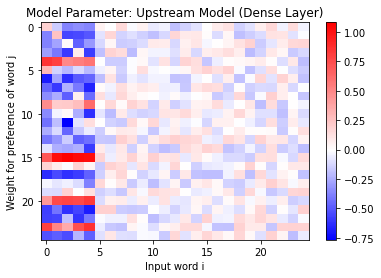

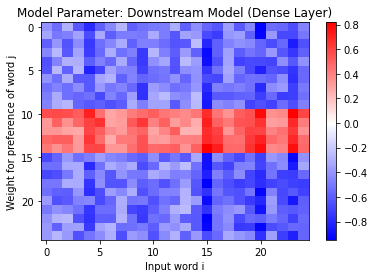

Text(0.5, 1.0, 'Upstream Loss (Retriever Loss)')

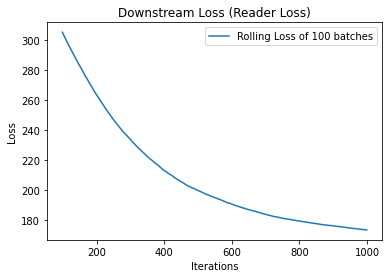

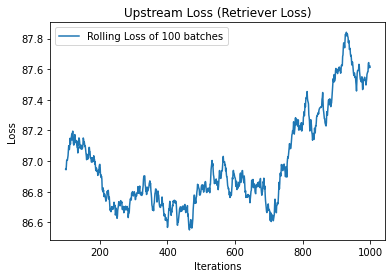

In [29]:
#Plot for inspection
plot_um = plot_weights(model_weights_um,model_name = 'Upstream Model')
plot_um.show()

plot_dm = plot_weights(model_weights_dm,model_name = 'Downstream Model')
plot_dm.show()

#Downstream Loss (Used for backward pass)
#Rolling loss: Reader Loss
plot_rolling_loss(reader_loss_vector,window = 100,normalize_loss = False)
plt.title('Downstream Loss (Reader Loss)')

#Retreaval Loss (i.e. loss after upstream model, not used in backward pass)
#Rolling loss: Retriever Loss
plot_rolling_loss(retriever_loss_vector,window = 100,normalize_loss = False)
plt.title('Upstream Loss (Retriever Loss)')